In [12]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import matplotlib.ticker as ticker
from adjustText import adjust_text
import mplcursors
import fabio
import ipywidgets as widgets
from IPython.display import display
import scipy.spatial.transform as transform
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from ipywidgets import widgets, HBox, VBox, Layout

In [45]:
def rotate_vector_with_quaternion(v, axis, angle_degree):
    """
    Rotates a vector 'v' around the 'axis' by 'angle_degree' degrees using quaternions.
    """
    angle_rad = np.radians(angle_degree)
    # Normalize the rotation axis
    axis = axis / np.linalg.norm(axis)
    # Create a quaternion for the rotation
    q = transform.Rotation.from_rotvec(axis * angle_rad)
    # Rotate the vector
    v_rotated = q.apply(v)
    return v_rotated

def any_within_tolerance(value_list, target_value, tolerance=0.05):
    return any(abs(value - target_value) <= tolerance for value in value_list)

def calculate_q_and_chi(h, k, l, a_star, b_star, c_star):
    """
    Calculate the magnitude of q and the declination angle chi from the qz axis for given Miller indices.

    :param h, k, l: Miller indices.
    :param a_star, b_star, c_star: Reciprocal lattice vectors.
    :return: Tuple containing the magnitude of q and the declination angle chi in degrees.
    """
    # Calculate q vector
    q = h * a_star + k * b_star + l * c_star

    # Calculate the magnitude of q
    q_magnitude = np.linalg.norm(q)

    # Calculate the declination angle chi (angle from qz-axis)
    if q_magnitude != 0:
        cos_chi = q[2] / q_magnitude  # q[2] is the z-component of q
        chi = np.arccos(cos_chi) * 180 / np.pi  # Convert to degrees
    else:
        chi = 0  # When q is zero vector, chi is set to 0

    return q_magnitude, chi

def find_miller_indices_for_q_magnitude(target_q_magnitude, a_star, b_star, c_star, tolerance=0.1, hkl_range=range(0, 4)):
    """
    Find Miller indices guesses that approximately match a given q magnitude.
    
    :param target_q_magnitude: The target q magnitude.
    :param a_star, b_star, c_star: Reciprocal lattice vectors.
    :param tolerance: The tolerance for matching q magnitudes.
    :param hkl_range: The range of values for h, k, and l.
    :return: List of tuples, each containing Miller indices, q magnitude, and chi.
    """
    valid_guesses = []
    for h in hkl_range:
        for k in hkl_range:
            for l in hkl_range:
                q_magnitude, chi = calculate_q_and_chi(h, k, l, a_star, b_star, c_star)
                if abs(q_magnitude - target_q_magnitude) <= tolerance:
                    valid_guesses.append(((h, k, l), q_magnitude, chi))
    
    return valid_guesses

def find_miller_indices_for_q_magnitude_neg(target_q_magnitude, a_star, b_star, c_star, tolerance=0.1, hkl_range=range(0, 4)):
    """
    Find Miller indices guesses that approximately match a given q magnitude.
    
    :param target_q_magnitude: The target q magnitude.
    :param a_star, b_star, c_star: Reciprocal lattice vectors.
    :param tolerance: The tolerance for matching q magnitudes.
    :param hkl_range: The range of values for h, k, and l.
    :return: List of tuples, each containing Miller indices, q magnitude, and chi.
    """
    valid_guesses = []
    for h in hkl_range:
        for k in hkl_range:
            for l in hkl_range:
                q_magnitude, chi = calculate_q_and_chi(h, k, l, a_star, b_star, c_star)
                if abs(q_magnitude - target_q_magnitude) <= tolerance:
                    valid_guesses.append(((h, k, l), q_magnitude, chi))
    
    return valid_guesses

def plot_combined_giwaxs_and_miller_indices_nolabel(img_path, qxy_path, qz_path, peaks):
    """
    Plots the GIWAXS detector image and overlays Miller indices.
    """
    # Load the GIWAXS image and q-coordinates
    img_array = fabio.open(img_path).data
    qxy = np.loadtxt(qxy_path)
    qz = np.loadtxt(qz_path)

    # Create a plot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot the GIWAXS image
    img_min = np.percentile(img_array, 1)
    img_max = np.percentile(img_array, 99.8)
    ax.imshow(img_array,
              norm=matplotlib.colors.Normalize(vmin=img_min, vmax=img_max),
              # norm=matplotlib.colors.LogNorm(vmin=np.percentile(img_array, 50), vmax=np.percentile(img_array, 99.9)),
              cmap='turbo',
              extent=(np.min(qxy), np.max(qxy), np.min(qz), np.max(qz)),
              origin='lower')

    # Overlay Miller indices
    points = []
    for peak in peaks:
        miller_indices, q_magnitude, chi = peak
        chi_radians = np.radians(chi)
        qz_val = q_magnitude * np.cos(chi_radians)
        qxy_val = q_magnitude * np.sin(chi_radians)
        
        # Plotting the point
        if qz_val < 0.02:
            qz_val += 0.02
        if chi < 91:
            point, = ax.plot(qxy_val, qz_val, 'o', color='white', markersize=5, markeredgecolor='black')
            point.set_gid(miller_indices)
            points.append(point)

    # Enable mplcursors
    cursor = mplcursors.cursor(points, hover=True)
    cursor.connect(
        "add", 
        lambda sel: sel.annotation.set_text(sel.artist.get_gid())
    )

    # Customizing annotation position
    cursor.connect(
        "add", 
        lambda sel: sel.annotation.set_position((0.1, 0.1))
    )


    ax.set_ylim(0, 1.9)
    ax.set_xlim(-1.1, 1.9)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax.set_xlabel('$\mathregular{q_{xy}}$ ($\AA^{-1}$)', size=12)
    ax.set_ylabel('$\mathregular{q_z}$ ($\AA^{-1}$)', size=12)
    ax.tick_params(axis='both', which='major', labelsize=10)
    plt.tight_layout()
    # plt.show()

def plot_combined_giwaxs_and_miller_indices_nolabel2(img_array, qxy, qz, peaks):
    """
    Plots the GIWAXS detector image and overlays Miller indices.
    """
    # Load the GIWAXS image and q-coordinates
    # img_array = fabio.open(img_path).data
    # qxy = np.loadtxt(qxy_path)
    # qz = np.loadtxt(qz_path)

    # Create a plot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot the GIWAXS image
    img_min = np.percentile(img_array, 1)
    img_max = np.percentile(img_array, 99.8)
    ax.imshow(img_array,
              norm=matplotlib.colors.Normalize(vmin=img_min, vmax=img_max),
              # norm=matplotlib.colors.LogNorm(vmin=np.percentile(img_array, 50), vmax=np.percentile(img_array, 99.9)),
              cmap='turbo',
              extent=(np.min(qxy), np.max(qxy), np.min(qz), np.max(qz)),
              origin='lower')

    # Overlay Miller indices
    points = []
    for peak in peaks:
        miller_indices, q_magnitude, chi = peak
        chi_radians = np.radians(chi)
        qz_val = q_magnitude * np.cos(chi_radians)
        qxy_val = q_magnitude * np.sin(chi_radians)
        
        # Plotting the point
        if qz_val < 0.02:
            qz_val += 0.02
        if chi < 91:
            point, = ax.plot(-qxy_val, qz_val, 'o', color='white', markersize=5, markeredgecolor='black')
            point.set_gid(miller_indices)
            points.append(point)
        # if chi > 89.9:
        #     point, = ax.plot(qxy_val, qz_val, 'o', color='white', markersize=5, markeredgecolor='black')
        #     point.set_gid(miller_indices)
        #     points.append(point)

    # Enable mplcursors
    cursor = mplcursors.cursor(points, hover=True)
    cursor.connect(
        "add", 
        lambda sel: sel.annotation.set_text(sel.artist.get_gid())
    )

    # Customizing annotation position
    cursor.connect(
        "add", 
        lambda sel: sel.annotation.set_position((0.1, 0.1))
    )


    # ax.set_ylim(0, 2.2)
    # ax.set_xlim(-2.2, 2.2)

    ax.set_ylim(0, 1.8)
    ax.set_xlim(-2, 2)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax.set_xlabel('$\mathregular{q_{xy}}$ ($\AA^{-1}$)', size=16)
    ax.set_ylabel('$\mathregular{q_z}$ ($\AA^{-1}$)', size=16)
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.tight_layout()
    # plt.show()
    
def plot_combined_giwaxs_and_unitcell(img_path, qxy_path, qz_path, peaks, a, b, c, draw_cell=True):
    """
    Plots the GIWAXS detector image and overlays Miller indices.
    """
    # Load the GIWAXS image and q-coordinates
    img_array = fabio.open(img_path).data
    qxy = np.loadtxt(qxy_path)
    qz = np.loadtxt(qz_path)
    
    img_array = np.flipud(img_array)
    qz = np.flip(qz)

    # Set up the figure and axes
    fig = plt.figure(figsize=(15, 6))
    ax1 = fig.add_subplot(121)  # For the GIWAXS plot
    if draw_cell:
        ax2 = fig.add_subplot(122, projection='3d')  # For the 3D unit cell
        ax2.view_init(elev=15, azim=45)
        ax2.set_proj_type('ortho')
    
        # Convert a, b, c from tuples to numpy arrays
        a = np.array(a)
        b = np.array(b)
        c = np.array(c)
        
        # Calculate the center of the unit cell
        center = (a + b + c) / 2
        cell_size = max(np.linalg.norm(v) for v in [a, b, c])
        fixed_limit = cell_size * 1.5  # 50% larger for substrate size
    
        # Adjust plot limits to keep the unit cell centered
        ax2.set_xlim(center[0] - fixed_limit, center[0] + fixed_limit)
        ax2.set_ylim(center[1] - fixed_limit, center[1] + fixed_limit)
        ax2.set_zlim(-fixed_limit, fixed_limit)
        
        # Define vertices of the parallelepiped (unit cell)
        vertices = np.array([
            [0, 0, 0],  # origin
            a,  # a
            b,  # b
            c,  # c
            a+b,  # a+b
            a+c,  # a+c
            b+c,  # b+c
            a+b+c,  # a+b+c
        ])

        # Define the vertices that compose each of the 6 faces
        faces = [
            [vertices[0], vertices[1], vertices[4], vertices[2]],  # Front face
            [vertices[0], vertices[1], vertices[5], vertices[3]],  # Left face
            [vertices[0], vertices[2], vertices[6], vertices[3]],  # Right face
            [vertices[7], vertices[4], vertices[1], vertices[5]],  # Back face
            [vertices[7], vertices[6], vertices[2], vertices[4]],  # Top face
            [vertices[7], vertices[5], vertices[3], vertices[6]],  # Bottom face
        ]

        # Create a Poly3DCollection for the faces
        face_collection = Poly3DCollection(faces, 
                                           facecolors='cyan', 
                                           linewidths=1, 
                                           edgecolors='black', 
                                           alpha=0.9)
        
        # Add the collection to the axis
        ax2.add_collection3d(face_collection)
    
         # Clean up the 3D axes
        ax2.set_box_aspect([1, 1, 1])
        ax2.set_xlabel('X')
        ax2.set_ylabel('Y')
        ax2.set_zlabel('Z')
        ax2.grid(False)  # Turn off the grid
        ax2.xaxis.set_ticklabels([])  # Hide x-axis ticks
        ax2.yaxis.set_ticklabels([])  # Hide y-axis ticks
        ax2.zaxis.set_ticklabels([])  # Hide z-axis ticks

    
    # Plot the GIWAXS image
    img_min = np.percentile(img_array, 1)
    img_max = np.percentile(img_array, 99.8)
    ax1.imshow(img_array,
              norm=matplotlib.colors.Normalize(vmin=img_min, vmax=img_max),
              # norm=matplotlib.colors.LogNorm(vmin=np.percentile(img_array, 50), vmax=np.percentile(img_array, 99.9)),
              cmap='turbo',
              extent=(np.min(qxy), np.max(qxy), np.min(qz), np.max(qz)),
              origin='lower')
    
    # Overlay Miller indices
    points = []
    for peak in peaks:
        miller_indices, q_magnitude, chi = peak
        chi_radians = np.radians(chi)
        qz_val = q_magnitude * np.cos(chi_radians)
        qxy_val = q_magnitude * np.sin(chi_radians)
        
        # Plotting the point
        if qz_val < 0.02:
            qz_val += 0.02
        if chi < 91:
            point, = ax1.plot(qxy_val, qz_val, 'o', color='white', markersize=5, markeredgecolor='black')
            point.set_gid(miller_indices)
            points.append(point)

    # Enable mplcursors
    cursor = mplcursors.cursor(points, hover=True)
    cursor.connect(
        "add", 
        lambda sel: sel.annotation.set_text(sel.artist.get_gid())
    )

    # Customizing annotation position
    cursor.connect(
        "add", 
        lambda sel: sel.annotation.set_position((0.1, 0.1))
    )


    ax1.set_ylim(0, 1.9)
    ax1.set_xlim(-1.1, 1.9)
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax1.set_xlabel('$\mathregular{q_{xy}}$ ($\AA^{-1}$)', size=12)
    ax1.set_ylabel('$\mathregular{q_z}$ ($\AA^{-1}$)', size=12)
    ax1.tick_params(axis='both', which='major', labelsize=10)
    # plt.tight_layout()
    # plt.show()
    
def calc_real_space(monomer_d, lamella_d, pi_d, pi_shift, lamella_shift):
    ax = lamella_d 
    ay = 0
    az = (lamella_shift/360) * monomer_d
    a = np.array([ax, ay, az])
    
    bx = 0
    by = pi_d
    bz = (pi_shift/360) * monomer_d
    b = np.array([bx, by, bz])
    
    cx = 0
    cy = 0
    cz = monomer_d
    c = np.array([cx, cy, cz])
    
    return a, b, c

def calc_real_space_abc(a_mag, b_mag, c_mag, alpha_deg, beta_deg, gamma_deg):
    '''
    https://www.ucl.ac.uk/~rmhajc0/frorth.pdf
    '''
    alpha = np.deg2rad(alpha_deg)
    beta = np.deg2rad(beta_deg)
    gamma = np.deg2rad(gamma_deg)
    
    V = a_mag*b_mag*c_mag*np.sqrt(1-np.cos(alpha)**2-np.cos(beta)**2-np.cos(gamma)**2+2*np.cos(alpha)*np.cos(beta)*np.cos(gamma)) 
    
    ax = a_mag
    ay = 0
    az = 0
    a = np.array([ax, ay, az])
    
    bx = b_mag*np.cos(gamma)
    by = b_mag*np.sin(gamma)
    bz = 0
    b = np.array([bx, by, bz])
    
    cx = c_mag*np.cos(beta)
    cy = c_mag*(np.cos(alpha)-np.cos(beta)*np.cos(gamma))/(np.sin(gamma))
    cz = V/(a_mag*b_mag*np.sin(gamma))
    c = np.array([cx, cy, cz])

    # print(V)
    # print(np.dot(a, np.cross(b,c)))
    
    return a, b, c

def calc_reciprocal_space(a, b, c):
    volume = np.dot(a, np.cross(b,c))
    a_star = 2 * np.pi * (np.cross(b,c) / volume)
    b_star = 2 * np.pi * (np.cross(c,a) / volume)
    c_star = 2 * np.pi * (np.cross(a,b) / volume)
    
    return a_star, b_star, c_star

def rot_matrix(u,theta):
    '''
    Generates a rotation matrix given a unit vector and angle
    see https://en.wikipedia.org/wiki/Rotation_matrix#Rotation_matrix_from_axis_and_angle

    Input
      u = unit vector in 3d cartesian coords about which the rotation will occur
      theta = angle in rad to rotate
    '''
    ux = u[0]
    uy = u[1]
    uz = u[2]
    R = np.zeros((3,3))
    R[0,0] = np.cos(theta)+ux**2*(1-np.cos(theta))
    R[0,1] = ux*uy*(1-np.cos(theta))-uz*np.sin(theta)
    R[0,2] = ux*uz*(1-np.cos(theta))+uy*np.sin(theta)
    R[1,0] = uy*ux*(1-np.cos(theta))+uz*np.sin(theta)
    R[1,1] = np.cos(theta)+uy**2*(1-np.cos(theta))
    R[1,2] = uy*uz*(1-np.cos(theta))-ux*np.sin(theta)
    R[2,0] = uz*ux*(1-np.cos(theta))-uy*np.sin(theta)
    R[2,1] = uz*uy*(1-np.cos(theta))+ux*np.sin(theta)
    R[2,2] = np.cos(theta)+uz**2*(1-np.cos(theta))
    
    return R

def rotate_lattice(a, b, c, rotation_axis, rotation_degrees):
    rotation_axis = np.array(rotation_axis)/np.linalg.norm(rotation_axis)
    rotation_rads = rotation_degrees * np.pi/180
    rot_mat = rot_matrix(rotation_axis, rotation_rads)
    a_rot = np.matmul(rot_mat,a)
    b_rot = np.matmul(rot_mat,b)
    c_rot = np.matmul(rot_mat,c)
    
    return a_rot, b_rot, c_rot

# def simulate_lattice(a_mag, b_mag, c_mag, alpha_deg, beta_deg, gamma_deg, rot_x, rot_y, rot_z, img_name):
def simulate_lattice(a_mag, b_mag, c_mag, alpha_deg, beta_deg, gamma_deg, rot_x, rot_y, rot_z, img_array, qxy, qz, hkl_range):
    tolerance = 1.9
    #calculate real space lattice
    a, b, c = calc_real_space_abc(a_mag, b_mag, c_mag, alpha_deg, beta_deg, gamma_deg)

    # #rotate lattice
    if rot_x != 0:
        a, b, c = rotate_lattice(a, b, c, [1,0,0], rot_x)
    if rot_y != 0:
        a, b, c = rotate_lattice(a, b, c, [0,1,0], rot_y)
    if rot_z != 0:
        a, b, c = rotate_lattice(a, b, c, [0,0,1], rot_z)
    
    #calculate reciprocal space lattice
    a_star, b_star, c_star = calc_reciprocal_space(a, b, c)
    
    #plot sample of peaks from reciprocal space lattice
    peaks = find_miller_indices_for_q_magnitude(0, a_star, b_star, c_star, tolerance=tolerance, hkl_range=hkl_range)
    # plot_combined_giwaxs_and_miller_indices_nolabel(img_path, qxy_path, qz_path, peaks)
    plot_combined_giwaxs_and_miller_indices_nolabel2(img_array, qxy, qz, peaks)  

def simulate_lattice_cart(a_x, a_y, a_z, b_x, b_y, b_z, c_x, c_y, c_z, rot_x, rot_y, rot_z, img_name):
    hkl_range = range(-3, 4)
    tolerance = 1.9
    #calculate real space lattice
    a = np.asarray([a_x, a_y, a_z])
    b = np.asarray([b_x, b_y, b_z])
    c = np.asarray([c_x, c_y, c_z])

    # #rotate lattice
    if rot_x != 0:
        a, b, c = rotate_lattice(a, b, c, [1,0,0], rot_x)
    if rot_y != 0:
        a, b, c = rotate_lattice(a, b, c, [0,1,0], rot_y)
    if rot_z != 0:
        a, b, c = rotate_lattice(a, b, c, [0,0,1], rot_z)
    
    #calculate reciprocal space lattice
    a_star, b_star, c_star = calc_reciprocal_space(a, b, c)
    
    #plot sample of peaks from reciprocal space lattice
    peaks = find_miller_indices_for_q_magnitude(0, a_star, b_star, c_star, tolerance=tolerance, hkl_range=hkl_range)
    plot_combined_giwaxs_and_miller_indices_nolabel(img_path, qxy_path, qz_path, peaks)
    
# Wrapper function that updates the plot based on slider values
def interactive_plot(a_mag, b_mag, c_mag, alpha_deg, beta_deg, gamma_deg, rot_x, rot_y, rot_z, draw_cell=False):
    # You can adjust the hkl_range and tolerance as needed
    hkl_range = range(-3, 4)
    tolerance = 1.9
    
    #calculate real space lattice
    a, b, c = calc_real_space_abc(a_mag, b_mag, c_mag, alpha_deg, beta_deg, gamma_deg)

    # #rotate lattice
    if rot_x != 0:
        a, b, c = rotate_lattice(a, b, c, [1,0,0], rot_x)
    if rot_y != 0:
        a, b, c = rotate_lattice(a, b, c, [0,1,0], rot_y)
    if rot_z != 0:
        a, b, c = rotate_lattice(a, b, c, [0,0,1], rot_z)
    
    #calculate reciprocal space lattice
    a_star, b_star, c_star = calc_reciprocal_space(a, b, c)
    
    # Call your simulate_lattice function
    peaks = find_miller_indices_for_q_magnitude(0, a_star, b_star, c_star, tolerance=tolerance, hkl_range=hkl_range)

    # Call your plot function
    plot_combined_giwaxs_and_unitcell(img_path, qxy_path, qz_path, peaks, a, b, c, draw_cell)

def interactive_plot_cart(a_x, a_y, a_z, b_x, b_y, b_z, c_x, c_y, c_z, rot_x, rot_y, rot_z, draw_cell=False):
    # You can adjust the hkl_range and tolerance as needed
    hkl_range = range(-3, 4)
    tolerance = 1.9

    a = np.asarray([a_x, a_y, a_z])
    b = np.asarray([b_x, b_y, b_z])
    c = np.asarray([c_x, c_y, c_z])
    # #rotate lattice
    if rot_x != 0:
        a, b, c = rotate_lattice(a, b, c, [1,0,0], rot_x)
    if rot_y != 0:
        a, b, c = rotate_lattice(a, b, c, [0,1,0], rot_y)
    if rot_z != 0:
        a, b, c = rotate_lattice(a, b, c, [0,0,1], rot_z)
    
    #calculate reciprocal space lattice
    a_star, b_star, c_star = calc_reciprocal_space(a, b, c)
    
    # Call your simulate_lattice function
    peaks = find_miller_indices_for_q_magnitude(0, a_star, b_star, c_star, tolerance=tolerance, hkl_range=hkl_range)

    # Call your plot function
    plot_combined_giwaxs_and_unitcell(img_path, qxy_path, qz_path, peaks, a, b, c, draw_cell)

def triclinic_box(x, y, z):
    """
    from: https://docs.mdanalysis.org/1.1.1/_modules/MDAnalysis/lib/mdamath.html#triclinic_box
    Convert the three triclinic box vectors to
    ``[lx, ly, lz, alpha, beta, gamma]``.

    If the resulting box is invalid, i.e., any box length is zero or negative,
    or any angle is outside the open interval ``(0, 180)``, a zero vector will
    be returned.

    All angles are in degrees and defined as follows:

    * ``alpha = angle(y,z)``
    * ``beta  = angle(x,z)``
    * ``gamma = angle(x,y)``

    Parameters
    ----------
    x : array_like
        Array of shape ``(3,)`` representing the first box vector
    y : array_like
        Array of shape ``(3,)`` representing the second box vector
    z : array_like
        Array of shape ``(3,)`` representing the third box vector

    Returns
    -------
    numpy.ndarray
        A numpy array of shape ``(6,)`` and dtype ``np.float32`` providing the
        unitcell dimensions in the same format as returned by
        :attr:`MDAnalysis.coordinates.base.Timestep.dimensions`:\n
        ``[lx, ly, lz, alpha, beta, gamma]``.\n
        Invalid boxes are returned as a zero vector.

    Note
    ----
    Definition of angles: http://en.wikipedia.org/wiki/Lattice_constant

    See Also
    --------
    :func:`~MDAnalysis.lib.mdamath.triclinic_vectors`


    .. versionchanged:: 0.20.0
       Calculations are performed in double precision and invalid box vectors
       result in an all-zero box.
    """
    x = np.asarray(x, dtype=np.float64)
    y = np.asarray(y, dtype=np.float64)
    z = np.asarray(z, dtype=np.float64)
    lx = norm(x)
    ly = norm(y)
    lz = norm(z)
    alpha = np.rad2deg(np.arccos(np.dot(y, z) / (ly * lz)))
    beta = np.rad2deg(np.arccos(np.dot(x, z) / (lx * lz)))
    gamma = np.rad2deg(np.arccos(np.dot(x, y) / (lx * ly)))
    box = np.array([lx, ly, lz, alpha, beta, gamma], dtype=np.float32)
    # Only positive edge lengths and angles in (0, 180) are allowed:
    if np.all(box > 0.0) and alpha < 180.0 and beta < 180.0 and gamma < 180.0:
        return box
    # invalid box, return zero vector:
    return np.zeros(6, dtype=np.float32)

# Wrapper function that updates the plot based on slider values
def interactive_plot_constantV(alpha_rel, beta_rel, gamma_rel, rot_x, rot_y, rot_z, draw_cell=False):
    '''
    This function maintains a constant volume based on an orthorhombic cell volume a_mag_init*b_mag_init*c_mag_init
    input angles (e.g. alpha_rel) describe single angle manipulations from orthorhombic cell 
    (these are not true triclinic angles but rather the angles if each manipulation were treated as monoclinic)
    '''
    # You can adjust the hkl_range and tolerance as needed
    hkl_range = range(-3, 4)
    tolerance = 1.9

    alpha = np.deg2rad(alpha_rel)
    beta = np.deg2rad(beta_rel)
    gamma = np.deg2rad(gamma_rel)
    a = [a_mag_init, 0, a_mag_init*np.tan(np.pi/2-beta)]
    b = [b_mag_init*np.tan(np.pi/2-gamma), b_mag_init, b_mag_init*np.tan(np.pi/2-alpha)]
    c = [0, 0, c_mag_init]

    # #rotate lattice
    if rot_x != 0:
        a, b, c = rotate_lattice(a, b, c, [1,0,0], rot_x)
    if rot_y != 0:
        a, b, c = rotate_lattice(a, b, c, [0,1,0], rot_y)
    if rot_z != 0:
        a, b, c = rotate_lattice(a, b, c, [0,0,1], rot_z)
    
    #calculate reciprocal space lattice
    a_star, b_star, c_star = calc_reciprocal_space(a, b, c)
    
    # Call your simulate_lattice function
    peaks = find_miller_indices_for_q_magnitude(0, a_star, b_star, c_star, tolerance=tolerance, hkl_range=hkl_range)

    # Call your plot function
    plot_combined_giwaxs_and_unitcell(img_path, qxy_path, qz_path, peaks, a, b, c, draw_cell)

def simulate_lattice_constantV(a_mag_init, b_mag_init, c_mag_init, alpha_rel, beta_rel, gamma_rel, rot_x, rot_y, rot_z, img_name):
    hkl_range = range(-3, 4)
    tolerance = 1.9
    #calculate real space lattice
    alpha = np.deg2rad(alpha_rel)
    beta = np.deg2rad(beta_rel)
    gamma = np.deg2rad(gamma_rel)
    a = [a_mag_init, 0, a_mag_init*np.tan(np.pi/2-beta)]
    b = [b_mag_init*np.tan(np.pi/2-gamma), b_mag_init, b_mag_init*np.tan(np.pi/2-alpha)]
    c = [0, 0, c_mag_init]

    # #rotate lattice
    if rot_x != 0:
        a, b, c = rotate_lattice(a, b, c, [1,0,0], rot_x)
    if rot_y != 0:
        a, b, c = rotate_lattice(a, b, c, [0,1,0], rot_y)
    if rot_z != 0:
        a, b, c = rotate_lattice(a, b, c, [0,0,1], rot_z)
    
    #calculate reciprocal space lattice
    a_star, b_star, c_star = calc_reciprocal_space(a, b, c)
    
    #plot sample of peaks from reciprocal space lattice
    peaks = find_miller_indices_for_q_magnitude(0, a_star, b_star, c_star, tolerance=tolerance, hkl_range=hkl_range)
    plot_combined_giwaxs_and_miller_indices_nolabel(img_path, qxy_path, qz_path, peaks)

# Simuate bragg peaks for standard triclinic cell (interactive sliders)

In [43]:
%matplotlib inline
#initial parameters
# a_mag = 21
# b_mag = 19.5
# c_mag = 3.6
# alpha_deg = 90
# beta_deg = 90
# gamma_deg = 90
# rot_x = -20
# rot_y = 0
# rot_z = 0
# a_mag = 25.57
# b_mag = 7.80
# c_mag = 14.57
# alpha_deg = 87.50
# beta_deg = 88
# gamma_deg = 89.13
# rot_x = 0
# rot_y = -92.5
# rot_z = 0
#form2
a_mag = 23.98
b_mag = 7.96
c_mag = 14.83
alpha_deg = 87.5
beta_deg = 88
gamma_deg = 89.13
rot_x = 0
rot_y = -92
rot_z = 0

# img_name = 'TC11'
# dir_path = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/OPV_GIWAXS/NSLS2_March2024/CDavis2'
# img_path = f'{dir_path}/reduced/q_maps/{img_name}/{img_name}_th0.15_qmap.tif'
# qxy_path = f'{dir_path}/reduced/q_maps/{img_name}/{img_name}_th0.15_qxy.txt'
# qz_path = f'{dir_path}/reduced/q_maps/{img_name}/{img_name}_th0.15_qz.txt'
# img_name = 'N2200_form4'
# exp_path = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/OPV_GIWAXS/N2200_simulation/exp/N2200_form4/'
# img_path = f'{exp_path}{img_name}_qmap.tif'
img_name = 'N2200_form2'
exp_path = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/OPV_GIWAXS/N2200_simulation/exp/N2200_form2/'
img_path = f'{exp_path}{img_name}_qmap.tif'
qxy_path = f'{exp_path}{img_name}_qxy.txt'
qz_path = f'{exp_path}{img_name}_qz.txt'
# img_path = f'{exp_path}{img_name}_det_sum.tif'
# qxy_path = f'{exp_path}{img_name}det_h.txt'
# qz_path = f'{exp_path}{img_name}det_v.txt'

print('Cell orientation view to the right is not completely reliable and gimbal lock is an issue \nKeep in mind that without any rotations: \na is defined along x-axis, \nb is defined within xy plane, \nc must point so that a-->b is ccw looking down from c')

# Cell dimensions
a_mag_slider = widgets.FloatSlider(min=a_mag*0.1, max=a_mag*2, step=0.1, value=a_mag, description='a_mag')
b_mag_slider = widgets.FloatSlider(min=b_mag*0.1, max=b_mag*2, step=0.1, value=b_mag, description='b_mag')
c_mag_slider = widgets.FloatSlider(min=c_mag*0.1, max=c_mag*2, step=0.1, value=c_mag, description='c_mag')
cell_dimensions_box = VBox([a_mag_slider, b_mag_slider, c_mag_slider])

# Cell angles
alpha_deg_slider = widgets.FloatSlider(min=1, max=179, step=1, value=alpha_deg, description='alpha_deg')
beta_deg_slider = widgets.FloatSlider(min=1, max=179, step=1, value=beta_deg, description='beta_deg')
gamma_deg_slider = widgets.FloatSlider(min=1, max=179, step=1, value=gamma_deg, description='gamma_deg')
cell_angles_box = VBox([alpha_deg_slider, beta_deg_slider, gamma_deg_slider])

# Cell rotations
rot_x_slider = widgets.FloatSlider(min=-180, max=180, step=0.5, value=rot_x, description='rot_x')
rot_y_slider = widgets.FloatSlider(min=-180, max=180, step=0.5, value=rot_y, description='rot_y')
rot_z_slider = widgets.FloatSlider(min=-180, max=180, step=0.5, value=rot_z, description='rot_z')
draw_cell_checkbox = widgets.Checkbox(value=False, description='Draw Cell')
cell_rotations_box = VBox([rot_x_slider, rot_y_slider, rot_z_slider])
cell_rotations_box.children += (draw_cell_checkbox,)

# Arrange the groups of sliders into three columns
sliders_box = HBox([cell_dimensions_box, cell_angles_box, cell_rotations_box])

# Use widgets.interactive to link the sliders to the plotting function
interactive_widget = widgets.interactive_output(interactive_plot, 
                                                {'a_mag': a_mag_slider, 
                                                 'b_mag': b_mag_slider, 
                                                 'c_mag': c_mag_slider, 
                                                 'alpha_deg': alpha_deg_slider, 
                                                 'beta_deg': beta_deg_slider, 
                                                 'gamma_deg': gamma_deg_slider,
                                                 'rot_x': rot_x_slider, 
                                                 'rot_y': rot_y_slider, 
                                                 'rot_z': rot_z_slider,
                                                 'draw_cell': draw_cell_checkbox})

# Display the sliders and the interactive plot together
display(sliders_box, interactive_widget)

Cell orientation view to the right is not completely reliable and gimbal lock is an issue 
Keep in mind that without any rotations: 
a is defined along x-axis, 
b is defined within xy plane, 
c must point so that a-->b is ccw looking down from c


Output()

# Simulate bragg peaks (hover with mouse for hkl labels)
### sometimes clicking on plot is necessary to show hkl labels

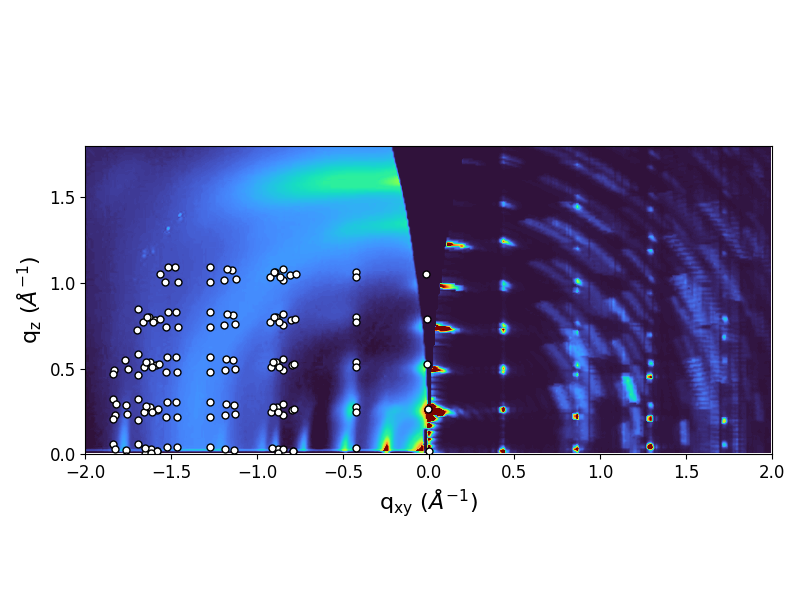

In [50]:
#initial parameters
%matplotlib widget
# a_mag = 21
# b_mag = 10.4
# c_mag = 19.5
# alpha_deg = 20
# beta_deg = 90
# gamma_deg = 90

# rot_x = -20
# rot_y = 0
# rot_z = 0

# img_name = 'TC11'
# dir_path = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/OPV_GIWAXS/NSLS2_March2024/CDavis2'
# img_path = f'{dir_path}/reduced/q_maps/{img_name}/{img_name}_th0.15_qmap.tif'
# qxy_path = f'{dir_path}/reduced/q_maps/{img_name}/{img_name}_th0.15_qxy.txt'
# qz_path = f'{dir_path}/reduced/q_maps/{img_name}/{img_name}_th0.15_qz.txt'

#form1a
# a_mag = 25.86
# b_mag = 4.00
# c_mag = 14.82
# alpha_deg = 86.05
# beta_deg = 69.09
# gamma_deg = 75.80
# rot_x = 89
# rot_y = 0
# rot_z = 0

#form1b
# a_mag = 25.50
# b_mag = 4.58
# c_mag = 14.32
# alpha_deg = 120.9
# beta_deg = 78.38
# gamma_deg = 86.00
# rot_x = 57
# rot_y = 0
# rot_z = 0

# #form2
a_mag = 23.98
b_mag = 7.96
c_mag = 14.83
alpha_deg = 87.5
beta_deg = 88
gamma_deg = 89.13
rot_x = 0
rot_y = -92
rot_z = 0

#form3
# a_mag = 25.97
# b_mag = 4.56
# c_mag = 28.21
# alpha_deg = 73.18
# beta_deg = 72
# gamma_deg = 83.98
# rot_x = 0
# rot_y = 0
# rot_z = 0




# img_name = 'N2200_form1a'
# exp_path = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/OPV_GIWAXS/N2200_simulation/exp/N2200_form1a/'
# img_path = f'{exp_path}{img_name}_qmap.tif'
# qxy_path = f'{exp_path}{img_name}_qxy.txt'
# qz_path = f'{exp_path}{img_name}_qz.txt'

sim_name = 'form2UC'
dirr = f'/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/OPV_GIWAXS/N2200_simulation/sim_data/{sim_name}/'
img_array = np.load(f'{dirr}{sim_name}_exp_img.npy')
qxy = np.load(f'{dirr}{sim_name}_exp_xaxis.npy')
qz = np.load(f'{dirr}{sim_name}_exp_yaxis.npy')

hkl_range = range(-4, 5)

simulate_lattice(a_mag, b_mag, c_mag, alpha_deg, beta_deg, gamma_deg, rot_x, rot_y, rot_z, img_array, qxy, qz, hkl_range)

In [51]:
dirr = f'/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/OPV_GIWAXS/N2200_simulation/sim_data/{sim_name}/'
plt.savefig(f'{dirr}{sim_name}_exp_overlay.png', dpi=300)

# Simuate bragg peaks for "constant volume cell"
#### mag_init values describe initial cell dimensions for a theoretical orthorhombic cell
#### angle_rel values describe a theoretical individual transformation onto the orthorhombic cell **while maintaining unit cell volume**
#### this is useful if you would like to change relative angle between matching moieties of adjacent chains without changing lamella d-spacing

### Convert triclinic cell to equal volume orthorhombic cell

In [6]:
# a_mag = 21
# b_mag = 10.4
# c_mag = 19.5
# alpha_deg = 20
# beta_deg = 90
# gamma_deg = 90
# a, b, c = calc_real_space_abc(a_mag, b_mag, c_mag, alpha_deg, beta_deg, gamma_deg)
# a_ortho_mag = a_mag
# b_ortho_mag = b_mag * np.cos(np.deg2rad(90-gamma_deg))
# c_ortho_mag = c_mag * 

# print(f'a_mag_init = {a[0]}')
# print(f'b_mag_init = {b[1]}')
# print(f'c_mag_init = {c[2]}')

# print(f'a_mag_init = {a[0]}')
# print(f'b_mag_init = {b[1]}')
# print(f'c_mag_init = {c[2]}')

SyntaxError: invalid syntax (3943099591.py, line 19)

In [8]:
%matplotlib inline
#initial parameters
a_mag_init = 21
b_mag_init = 3.6
c_mag_init = 19.5

alpha_rel = 90
beta_rel = 90
gamma_rel = 90

rot_x = 0
rot_y = 0
rot_z = 0

img_name = 'TC11'
dir_path = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/OPV_GIWAXS/NSLS2_March2024/CDavis2'
img_path = f'{dir_path}/reduced/q_maps/{img_name}/{img_name}_th0.15_qmap.tif'
qxy_path = f'{dir_path}/reduced/q_maps/{img_name}/{img_name}_th0.15_qxy.txt'
qz_path = f'{dir_path}/reduced/q_maps/{img_name}/{img_name}_th0.15_qz.txt'

a_mag = 25.53
b_mag = 4.55
c_mag = 14.63
alpha_deg = 58.10
beta_deg = 80
gamma_deg = 85
rot_x = -58.1
rot_y = 0
rot_z = 0
img_name = 'N2200_form4'
exp_path = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/OPV_GIWAXS/N2200_simulation/exp/N2200_form4/'
img_path = f'{exp_path}{img_name}_qmap.tif'
qxy_path = f'{exp_path}{img_name}_qxy.txt'
qz_path = f'{exp_path}{img_name}_qz.txt'



print('Cell orientation view to the right is not completely reliable and gimbal lock is an issue \nKeep in mind that without any rotations: \na is defined along x-axis, \nb is defined within xy plane, \nc must point so that a-->b is ccw looking down from c')

# Cell dimensions
# a_mag_slider = widgets.FloatSlider(min=a_mag*0.1, max=a_mag*2, step=0.1, value=a_mag, description='a_mag')
# b_mag_slider = widgets.FloatSlider(min=b_mag*0.1, max=b_mag*2, step=0.1, value=b_mag, description='b_mag')
# c_mag_slider = widgets.FloatSlider(min=c_mag*0.1, max=c_mag*2, step=0.1, value=c_mag, description='c_mag')
# cell_dimensions_box = VBox([a_mag_slider, b_mag_slider, c_mag_slider])

# Cell angles
alpha_deg_slider = widgets.FloatSlider(min=1, max=179, step=0.1, value=alpha_rel, description='alpha_rel')
beta_deg_slider = widgets.FloatSlider(min=1, max=179, step=0.1, value=beta_rel, description='beta_rel')
gamma_deg_slider = widgets.FloatSlider(min=1, max=179, step=0.1, value=gamma_rel, description='gamma_rel')
cell_angles_box = VBox([alpha_deg_slider, beta_deg_slider, gamma_deg_slider])

# Cell rotations
rot_x_slider = widgets.FloatSlider(min=-180, max=180, step=1, value=rot_x, description='rot_x')
rot_y_slider = widgets.FloatSlider(min=-180, max=180, step=1, value=rot_y, description='rot_y')
rot_z_slider = widgets.FloatSlider(min=-180, max=180, step=1, value=rot_z, description='rot_z')
draw_cell_checkbox = widgets.Checkbox(value=False, description='Draw Cell')
cell_rotations_box = VBox([rot_x_slider, rot_y_slider, rot_z_slider])
cell_rotations_box.children += (draw_cell_checkbox,)

# Arrange the groups of sliders into three columns
sliders_box = HBox([cell_angles_box, cell_rotations_box])

# Use widgets.interactive to link the sliders to the plotting function
interactive_widget = widgets.interactive_output(interactive_plot_constantV, 
                                                {'alpha_rel': alpha_deg_slider, 
                                                 'beta_rel': beta_deg_slider, 
                                                 'gamma_rel': gamma_deg_slider,
                                                 'rot_x': rot_x_slider, 
                                                 'rot_y': rot_y_slider, 
                                                 'rot_z': rot_z_slider,
                                                 'draw_cell': draw_cell_checkbox})

# Display the sliders and the interactive plot together
display(sliders_box, interactive_widget)

Cell orientation view to the right is not completely reliable and gimbal lock is an issue 
Keep in mind that without any rotations: 
a is defined along x-axis, 
b is defined within xy plane, 
c must point so that a-->b is ccw looking down from c


Output()

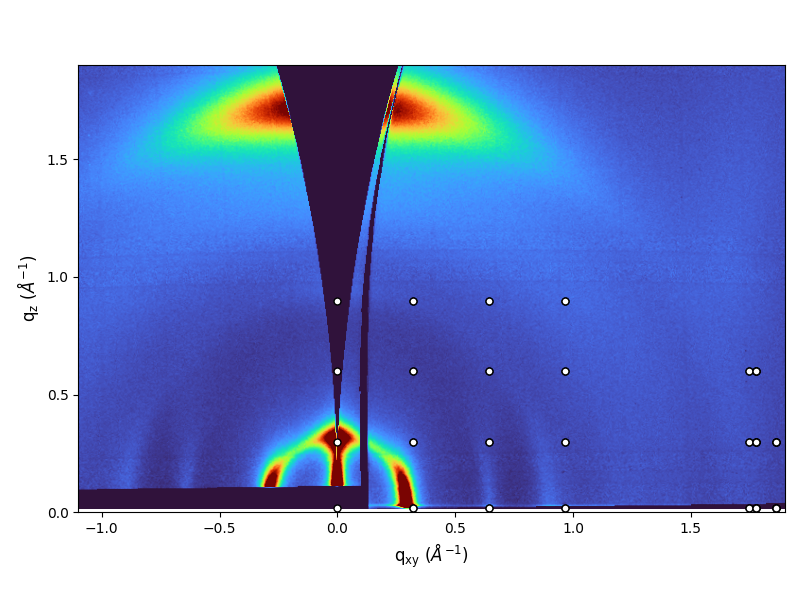

In [36]:
#initial parameters
%matplotlib widget
a_mag_init = 21
b_mag_init = 3.6
c_mag_init = 19.5

alpha_deg = 90
beta_deg = 90
gamma_deg = 90

rot_x = 90
rot_y = 90
rot_z = 0

img_name = 'TC11'
dir_path = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/OPV_GIWAXS/NSLS2_March2024/CDavis2'
img_path = f'{dir_path}/reduced/q_maps/{img_name}/{img_name}_th0.15_qmap.tif'
qxy_path = f'{dir_path}/reduced/q_maps/{img_name}/{img_name}_th0.15_qxy.txt'
qz_path = f'{dir_path}/reduced/q_maps/{img_name}/{img_name}_th0.15_qz.txt'

simulate_lattice_constantV(a_mag_init, b_mag_init, c_mag_init, alpha_deg, beta_deg, gamma_deg, rot_x, rot_y, rot_z, img_name)

# Define/modify triclinic cell by cartesian vector components

In [15]:
%matplotlib inline
#initial parameters
a_x, a_y, a_z = (21, 0, 9.75)
b_x, b_y, b_z = (0, 3.6, 9.75)
c_x, c_y, c_z = (0, 0, 19.5)
rot_x = 90
rot_y = 0
rot_z = 0

img_name = 'TC11'
dir_path = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/OPV_GIWAXS/NSLS2_March2024/CDavis2'
img_path = f'{dir_path}/reduced/q_maps/{img_name}/{img_name}_th0.15_qmap.tif'
qxy_path = f'{dir_path}/reduced/q_maps/{img_name}/{img_name}_th0.15_qxy.txt'
qz_path = f'{dir_path}/reduced/q_maps/{img_name}/{img_name}_th0.15_qz.txt'

print('Cell orientation view to the right is not completely reliable and gimbal lock is an issue \nKeep in mind that without any rotations: \na is defined along x-axis, \nb is defined within xy plane, \nc must point so that a-->b is ccw looking down from c')

# a dimensions
a_x_slider = widgets.FloatSlider(min=a_x-5, max=a_x+5, step=0.05, value=a_x, description='a_x')
a_y_slider = widgets.FloatSlider(min=a_y-5, max=a_y+5, step=0.05, value=a_y, description='a_y')
a_z_slider = widgets.FloatSlider(min=a_z-5, max=a_z+5, step=0.05, value=a_z, description='a_z')
cell_dimensions_box_a = VBox([a_x_slider, a_y_slider, a_z_slider])

# b dimensions
b_x_slider = widgets.FloatSlider(min=b_x-5, max=b_x+5, step=0.05, value=b_x, description='b_x')
b_y_slider = widgets.FloatSlider(min=b_y-5, max=b_y+5, step=0.05, value=b_y, description='b_y')
b_z_slider = widgets.FloatSlider(min=b_z-5, max=b_z+5, step=0.05, value=b_z, description='b_z')
cell_dimensions_box_b = VBox([b_x_slider, b_y_slider, b_z_slider])

# c dimensions
c_x_slider = widgets.FloatSlider(min=c_x-5, max=c_x+5, step=0.05, value=c_x, description='c_x')
c_y_slider = widgets.FloatSlider(min=c_y-5, max=c_y+5, step=0.05, value=c_y, description='c_y')
c_z_slider = widgets.FloatSlider(min=c_z-5, max=c_z+5, step=0.05, value=c_z, description='c_z')
cell_dimensions_box_c = VBox([c_x_slider, c_y_slider, c_z_slider])

# Cell rotations
rot_x_slider = widgets.FloatSlider(min=-180, max=180, step=1, value=rot_x, description='rot_x')
rot_y_slider = widgets.FloatSlider(min=-180, max=180, step=1, value=rot_y, description='rot_y')
rot_z_slider = widgets.FloatSlider(min=-180, max=180, step=1, value=rot_z, description='rot_z')
draw_cell_checkbox = widgets.Checkbox(value=False, description='Draw Cell')
cell_rotations_box = VBox([rot_x_slider, rot_y_slider, rot_z_slider])
cell_rotations_box.children += (draw_cell_checkbox,)

# Arrange the groups of sliders into three columns
sliders_box = HBox([cell_dimensions_box_a, cell_dimensions_box_b, cell_dimensions_box_c, cell_rotations_box])

# Use widgets.interactive to link the sliders to the plotting function
interactive_widget = widgets.interactive_output(interactive_plot_cart, 
                                                {'a_x': a_x_slider,
                                                 'a_y': a_y_slider,
                                                 'a_z': a_z_slider,
                                                 'b_x': b_x_slider,
                                                 'b_y': b_y_slider,
                                                 'b_z': b_z_slider,
                                                 'c_x': c_x_slider,
                                                 'c_y': c_y_slider,
                                                 'c_z': c_z_slider,
                                                 'rot_x': rot_x_slider, 
                                                 'rot_y': rot_y_slider, 
                                                 'rot_z': rot_z_slider,
                                                 'draw_cell': draw_cell_checkbox})

# Display the sliders and the interactive plot together
display(sliders_box, interactive_widget)

Cell orientation view to the right is not completely reliable and gimbal lock is an issue 
Keep in mind that without any rotations: 
a is defined along x-axis, 
b is defined within xy plane, 
c must point so that a-->b is ccw looking down from c


Output()

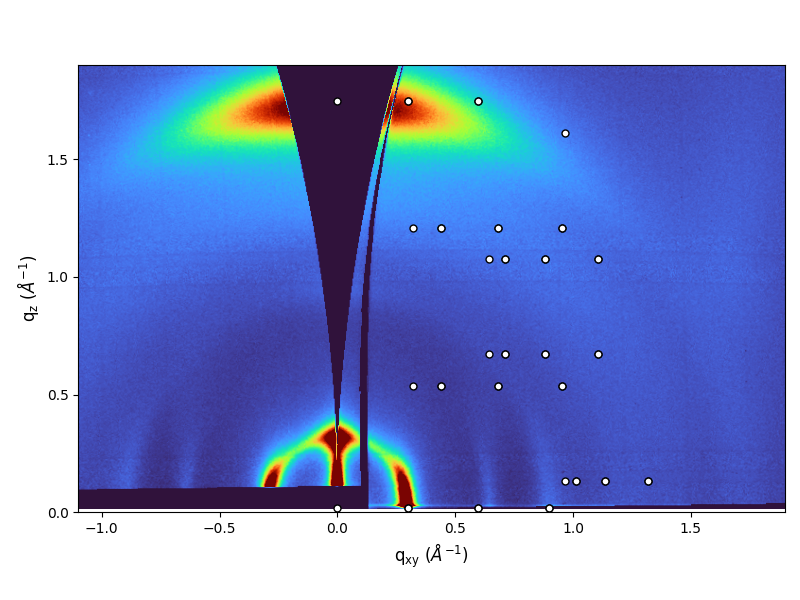

In [10]:
#initial parameters
%matplotlib widget
a_x, a_y, a_z = (21, 0, 0)
b_x, b_y, b_z = (0, 3.6, 6)
c_x, c_y, c_z = (0, 0, 19.5)
rot_x = 90
rot_y = 0
rot_z = 0

img_name = 'TC11'
dir_path = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/OPV_GIWAXS/NSLS2_March2024/CDavis2'
img_path = f'{dir_path}/reduced/q_maps/{img_name}/{img_name}_th0.15_qmap.tif'
qxy_path = f'{dir_path}/reduced/q_maps/{img_name}/{img_name}_th0.15_qxy.txt'
qz_path = f'{dir_path}/reduced/q_maps/{img_name}/{img_name}_th0.15_qz.txt'

simulate_lattice_cart(a_x, a_y, a_z, b_x, b_y, b_z, c_x, c_y, c_z, rot_x, rot_y, rot_z, img_name)

In [19]:
plt.close('all')

In [ ]:
a_mag, 
b_mag, c_mag, alpha_deg, beta_deg, gamma_deg

# You can adjust the hkl_range and tolerance as needed
hkl_range = range(-3, 4)
tolerance = 1.9

#calculate real space lattice
a, b, c = calc_real_space_abc(a_mag, b_mag, c_mag, alpha_deg, beta_deg, gamma_deg)

# #rotate lattice
if rot_x != 0:
    a, b, c = rotate_lattice(a, b, c, [1,0,0], rot_x)
if rot_y != 0:
    a, b, c = rotate_lattice(a, b, c, [0,1,0], rot_y)
if rot_z != 0:
    a, b, c = rotate_lattice(a, b, c, [0,0,1], rot_z)

#calculate reciprocal space lattice
a_star, b_star, c_star = calc_reciprocal_space(a, b, c)

# Call your simulate_lattice function
peaks = find_miller_indices_for_q_magnitude(0, a_star, b_star, c_star, tolerance=tolerance, hkl_range=hkl_range)

In [9]:
dirr = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/OPV_GIWAXS/N2200_simulation/exp/N2200_form3/'
gen_name = 'F3_lin_digitized'
# det_ints = np.load(f'{dirr}{gen_name}_det_sum.npy')
# # Create a TiffImage object from the numpy array
# tiff_image = fabio.tifimage.TifImage(data=det_ints)
# # Save the TiffImage object to a .tif file
# tiff_image.write(f'{dirr}{gen_name}_det_sum.tif')

det_ints = np.load(f'{dirr}{gen_name}_img.npy')
# Create a TiffImage object from the numpy array
tiff_image = fabio.tifimage.TifImage(data=det_ints)
# Save the TiffImage object to a .tif file
tiff_image.write(f'{dirr}{gen_name}_img.tif')


qxy_path = f'{dirr}{gen_name}_deth.txt'
qz_path = f'{dirr}{gen_name}_detv.txt'

qxy_data = np.load(f'{dirr}{gen_name}_xaxis.npy')
qz_data = np.load(f'{dirr}{gen_name}_yaxis.npy')
np.savetxt(qxy_path, qxy_data)
np.savetxt(qz_path, qz_data)